In [ ]:
#@title Authenticate Google Drive & Load Dataset
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 40+ images
#file_id = '1cri3RKBVE4i3FGewtI3E67dmbc8uOF7I'
# 7+ images
#file_id = '1VMXGATBfKNZ-l1B6u76mlD2DS1DvihQv'
# all categories
#file_id = '1xVKufqNVKvbPD5FGYNBNd-qPB8925kLI'
# 2 categories
#file_id = '1t5TItBGf1ccif1lTU9sfnShrWrH8_vA6'
#file_id = '1enlSgboQEdVEB4jRapl3-d99URO9oWSK'
file_id =  '1NYdJFei4nGzdxPbOlfm8-BjCq5WAJYgp'
#file_id = '131ZpgwnfgzCOjqoM89JjG9eY6kRo5au9'


downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('TM imagesCNN.zip')

from zipfile import ZipFile
data = ZipFile('TM imagesCNN.zip', 'r')
data.extractall()

     |████████████████████████████████| 993kB 3.5MB/s 

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [ ]:
DIR = "./TM imagesCNN"

In [ ]:
#!rm -r './TM imagesCNN/D3-Normal Ear'

In [ ]:
#@title Importing Libraries
import time
import random
import glob
import keras
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers, regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing import image
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

In [ ]:
#@title Dataset Stats
def dataset_stats():
    
    # This is an array with the all the diseases available in the directory.

    diseases = os.listdir(DIR)
    
    # dictionary where we will store the stats
    stats = []
    
    for disease in diseases:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, disease)))
        
    for sub_directory in directory_list:
        file_names = [file for file in os.listdir(sub_directory)]
        file_count = len(file_names)
        sub_directory_name = os.path.basename(sub_directory)
        stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                        "Image count": file_count, 
                       "Folder name": os.path.basename(sub_directory),
                        "File names": file_names})

    
    df = pd.DataFrame(stats)
    
    return df

In [ ]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]
type(dataset)

pandas.core.frame.DataFrame

In [ ]:
dataset

,File names,Folder name,Image count
Code,,,
D0,"[20180101000047-H0000002.JPG, 20180101000136-H...",D0-Acute otitis media,26
D1,"[20180101000141-H0000011.JPG, 20180101000044-H...",D1-Glue ear,16
D4,"[20180101000117-H0000002.JPG, 20180101000100-H...",D4-Otomycosis,21
D5,"[20180101000043-H0000007.JPG, 20180101000119-H...",D5-Safe CSOM,55
D6,"[20180101000047-H0000002.JPG, 20180101000218-H...",D6-Others,29


In [ ]:
#@title Load Images
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)
            
            # Removing black regions
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #mask = gray>100
            #image = image[np.ix_(mask.any(1),mask.any(0))]

            # Resize it to 224 x 224
            #image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
           # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)
            
            # Now save images
            #cv2.imwrite(file_path,image)

    return images, labels

In [ ]:
DF = dataset_stats()
codes = dataset_stats()['Code']
images, labels = load_images(codes)

In [ ]:
#@title Display Some Images

def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

In [ ]:
#show_random_images(images, labels)

In [ ]:
# Set aside the testing data. We won't touch these until the very end.
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=101)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=71)

In [ ]:
# Pre-processing images and labels
# scale the raw pixel intensities and labels to the range [0, 1]
X_train = np.array(X_train, dtype="float") / 255.0
X_val = np.array(X_val, dtype="float") / 255.0
X_test = np.array(X_test, dtype="float") / 255.0

In [ ]:
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2


In [ ]:
# Binarizng labels
lb = preprocessing.LabelBinarizer()
lb.fit(labels)
#lb.classes_
y_train = lb.transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [ ]:
# create the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 13 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

img_width, img_height = 224, 224

nb_train_samples = len(X_train)*20
nb_validation_samples = len(X_val)*6

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

# this is the augmentation configuration we will use for validating/testing:
# only rescaling
test_datagen = ImageDataGenerator()

# this is a generator that will indefinitely generate batches of augmented image data
train_generator = train_datagen.flow(X_train, y_train)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow(X_val, y_val)

# train the model on the new data for a few epochs
historyA = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // 128, epochs=50,
                    initial_epoch=0, validation_data=validation_generator, validation_steps=nb_validation_samples // 128)


Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 0s 0us/step
Instructions for updating:
Use tf.cast instead.
Epoch 1/50


In [ ]:
accA

[9.170934677124023, 0.25]

In [ ]:
 # Predicting the Test set results
y_pred = model.predict(X_test)
y_pred_a = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), y_pred_a.argmax(axis=1))

array([[0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 8, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0]])

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


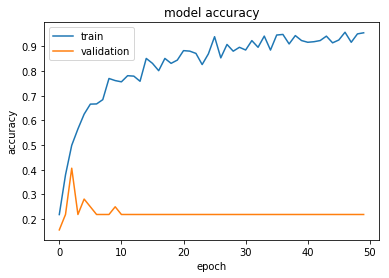

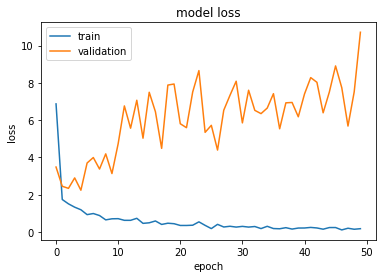

In [ ]:
print(historyA.history.keys())
#  "Accuracy"
plt.plot(historyA.history['categorical_accuracy'])
plt.plot(historyA.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(historyA.history['loss'])
plt.plot(historyA.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Predicting the Test set results
#y_pred = model.predict(X_test)
#y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred) 

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_8
1 Conv1_pad
2 Conv1
3 bn_Conv1
4 Conv1_relu
5 expanded_conv_depthwise
6 expanded_conv_depthwise_BN
7 expanded_conv_depthwise_relu
8 expanded_conv_project
9 expanded_conv_project_BN
10 block_1_expand
11 block_1_expand_BN
12 block_1_expand_relu
13 block_1_pad
14 block_1_depthwise
15 block_1_depthwise_BN
16 block_1_depthwise_relu
17 block_1_project
18 block_1_project_BN
19 block_2_expand
20 block_2_expand_BN
21 block_2_expand_relu
22 block_2_depthwise
23 block_2_depthwise_BN
24 block_2_depthwise_relu
25 block_2_project
26 block_2_project_BN
27 block_2_add
28 block_3_expand
29 block_3_expand_BN
30 block_3_expand_relu
31 block_3_pad
32 block_3_depthwise
33 block_3_depthwise_BN
34 block_3_depthwise_relu
35 block_3_project
36 block_3_project_BN
37 block_4_expand
38 block_4_expand_BN
39 block_4_expand_relu
40 block_4_depthwise
41 block_4_depthwise_BN
42 block_4_depthwise_relu
43 block_4_project
44 block_4_project_BN
45 block_4_add
46 block_5_expand
47 block_5_expand_BN
48 block_5_exp

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:108]:
   layer.trainable = False
for layer in model.layers[108:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0005, momentum=0.09), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
historyB = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // 128, epochs=50,
                    initial_epoch=0, validation_data=validation_generator, validation_steps=nb_validation_samples // 128)

Epoch 1/50
13/13 [==============================] - 94s 7s/step - loss: 0.5031 - categorical_accuracy: 0.8383 - val_loss: 5.1088 - val_categorical_accuracy: 0.2143
Epoch 2/50
13/13 [==============================] - 83s 6s/step - loss: 0.3442 - categorical_accuracy: 0.8824 - val_loss: 5.2647 - val_categorical_accuracy: 0.1735
Epoch 3/50
13/13 [==============================] - 83s 6s/step - loss: 0.3002 - categorical_accuracy: 0.9082 - val_loss: 5.1437 - val_categorical_accuracy: 0.1939
Epoch 4/50
13/13 [==============================] - 86s 7s/step - loss: 0.3143 - categorical_accuracy: 0.8803 - val_loss: 4.9046 - val_categorical_accuracy: 0.2245
Epoch 5/50
13/13 [==============================] - 83s 6s/step - loss: 0.2521 - categorical_accuracy: 0.9020 - val_loss: 4.8217 - val_categorical_accuracy: 0.2653
Epoch 6/50
13/13 [==============================] - 85s 7s/step - loss: 0.1598 - categorical_accuracy: 0.9330 - val_loss: 4.8075 - val_categorical_accuracy: 0.1939
Epoch 7/50
13/13

In [ ]:
# this is a generator for test data
test_generator = test_datagen.flow(X_test, y_test)

# let's test our model
accB = model.evaluate_generator(test_generator, steps=1,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

In [ ]:
accB

[6.388706207275391, 0.28125]

In [ ]:
 # Predicting the Test set results
y_pred = model.predict(X_test)
y_pred_a = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), y_pred_a.argmax(axis=1))

array([[2, 0, 0, 0, 0, 2, 0, 2],
       [0, 1, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 3, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 8, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0]])

In [ ]:
print(historyB.history.keys())
#  "Accuracy"
plt.plot(historyB.history['categorical_accuracy'])
plt.plot(historyB.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: ignored


# Model -- Accuracy (after fine-tuning)

InceptionV3 -- 61

Xception -- 62.5

VGG16 -- 56.25 (reduced from 59.3)

MobileNetV2 -- 